### Plotting the ADCP spectra

In [36]:
import numpy as np
from scipy import io

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset

In [37]:
plt.rcParams.update({'font.size': 25, 'legend.handlelength'  : 1.5
    , 'legend.markerscale': 1.})
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25)

In [38]:
c1 = '#6495ed'
c2 = '#d02090'
c3 = '#ff8c00'
c4 = '#3cb371'
c5 = 'w'

lw1=4
aph=.7
sc = 20.

In [39]:
# mapping
lonplot = (-70, -50)
latplot = (-67, -50)

m = Basemap(llcrnrlon=lonplot[0],llcrnrlat=latplot[0],urcrnrlon=lonplot[1],
        urcrnrlat=latplot[1],
            rsphere=(6378137.00,6356752.3142),
            resolution='i',area_thresh=1000.,projection='lcc',
            lat_1=-55,lon_0=-70)

In [40]:
# dataset
data = np.load('outputs/mean_currents3.npz')
xgm,ygm = m(data['xg'],data['yg'])

fronts = Dataset('outputs/SO_polar_fronts.v3.nc','r') 
lon_fronts = np.array(fronts.variables['lon'][:])
lat_saf = np.array(fronts.variables['latSAF'][:,:])
lat_pf = np.array(fronts.variables['latPF'][:,:])
time_fronts = np.array(fronts.variables['time'][:])
lon_fronts2 = np.repeat(lon_fronts,time_fronts.size).reshape(time_fronts.size,lon_fronts.size) 

lat_pfm = np.nanmean(lat_pf,axis=0)
lat_pfstd = np.nanstd(lat_pf,axis=0)
xpf,ypf=m(lon_fronts,lat_pfm)
xpfl,ypfl=m(lon_fronts,lat_pfm-lat_pfstd)
xpfu,ypfu=m(lon_fronts,lat_pfm+lat_pfstd)

# Lenn et al. 2008 Polar fronts
lenn = io.loadmat('outputs/lenn_polar',squeeze_me=True,struct_as_record=False)

xlm,ylm = m(lenn['xip'],lenn['yipm'])
xlu,ylu = m(lenn['xip'],lenn['yipm']+lenn['yips'])
xll,yll = m(lenn['xip'],lenn['yipm']-lenn['yips'])

In [41]:
# masking
U26 = np.ma.masked_array(data['U26'],data['NDOF26']<5)
V26 = np.ma.masked_array(data['V26'],data['NDOF26']<5)
var_U26 = np.ma.masked_array(data['var_U26'],data['NDOF26']<5)
var_V26 = np.ma.masked_array(data['var_V26'],data['NDOF26']<5)
var26=(var_U26+var_V26)/2.
e26 = var_U26/var_V26; f = (e26<1.); #e26[f] = 1./e26[f]
e26s = float((e26.mask == False).sum())

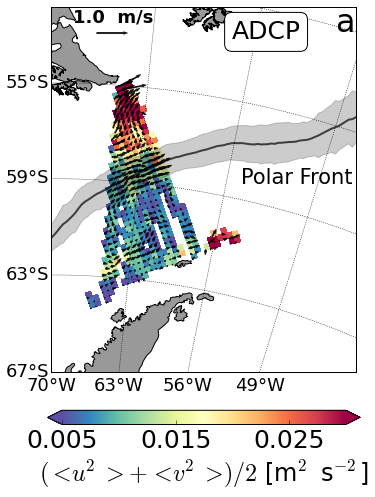

In [42]:

fig=plt.figure(facecolor='w', figsize=(8.,8.5))

m.pcolor(xgm,ygm,var26,cmap='Spectral_r',vmin=0.005,vmax=0.03)
cb = plt.colorbar(orientation='horizontal',shrink=.7,pad=0.08,extend='both')
cb.set_label(u'$(<u^2>+<v^2>)/2$ [m$^2$ s$^{-2}$]')
cb.set_ticks(np.arange(0.005,0.035,0.01))
#cb.set_ticklabels(ticks)

Q = m.quiver(xgm,ygm,U26,V26,color='k',scale=10,linewidths=1.,alpha=.8)

# quiver legend
qk = plt.quiverkey(Q, .2, .93, 1., '1.0  m/s',color='k', fontproperties={'weight': 'bold','size': '18'})

m.plot(xpf,ypf,'k',linewidth=2.,alpha=.7)
plt.fill_between(xpf,ypfl,ypfu, color='k', alpha=0.2)
plt.text(884397.07, 876462.09,'Polar Front',fontsize=21)

m.fillcontinents(color='.60',lake_color='none')
m.drawparallels(np.arange(latplot[0], latplot[1], 4),
    labels=[1, 0, 0, 0], linewidth=.5, 
    fontsize=18., fontweight='medium')
m.drawmeridians(np.arange(lonplot[0], lonplot[1]+4, 7),
    labels=[0, 0, 0, 1], dashes=[1,1], linewidth=.5, 
    fontsize=18., fontweight='medium')
m.drawcoastlines()

plt.text(999212.26, 1585373.07, "ADCP", size=25, rotation=0.,
         ha="center", va="center",
         bbox = dict(boxstyle="round",ec='k',fc='w'))

plt.text(1328212.26, 1585373.07, "a", fontsize=32)

plt.savefig('figs/var26',dpi=300,bbox_inches='tight')